#### Install packages (particular versions should not matter as long as they are Python > 3.6 compatible)

In [6]:
import os, sys, time, pickle, glob,scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numba import jit,njit, prange

#### Make sure you install the OASIS pacakge locally as instructed in  https://github.com/j-friedrich/OASIS

In [7]:
sys.path.append('/Users/yiqunc/Desktop/spring_2019/stat572/OASIS/')
import numpy as np
from matplotlib import pyplot as plt
from oasis import oasisAR1, oasisAR2
try:
    from oasis.functions import gen_data, constrained_foopsi
except:
    raise ImportError(
        'To produce this figure you actually need to have cvxpy installed.')
from oasis.plotting import init_fig, simpleaxis

In [8]:
def data_generation(T, theta, gamma, sigma, random_seed = 1234):
    """
    Generate data using an AR-1 process - same as paper's simulation condition 
    Input:
    T: timestep to simulate
    theta: firing rate
    gamma: decay rate
    sigma: noise parameter
    """
    
    np.random.seed(random_seed)
    s_t = np.random.poisson(lam = theta, size=T)
    c_0 = 1.0
    c_list = [c_0]
    F_list = [c_0+np.random.normal(loc=0,scale=sigma)]
    for i in range(1,T):
        curr_c = gamma*c_list[i-1]+s_t[i]
        c_list.append(curr_c)
        F_list.append(curr_c+np.random.normal(loc=0,scale=sigma))
    return([s_t,c_list,F_list])



In [9]:
@jit(nopython=True,parallel=True, fastmath=True)
def Dcost_func(y,gamma = 0.9):
    """
    for a given sequence, compute D(y_1,y_n) 
    """
    assert len(y)>=1, 'must have at least 1 data point'
    num_c = 0.
    denom_c = 0.
    cost = 0.
    for t,y_t in enumerate(y):
        num_c += y_t*np.power(gamma,t)
        denom_c += np.power(gamma,2*t)
    c_hat = num_c/denom_c
    for t,y_t in enumerate(y):
        cost += np.power(y_t-np.power(gamma,t)*c_hat,2)
    cost*=0.5
    return([c_hat,cost])

In [10]:
@jit(nopython=True,parallel=True, fastmath=True)
def backtrack_spike(back_vec):
    """
    Take in a list and backtrack where we estimated a spike for ell_0
    """
    # you start from the end
    estimated_spike = []
    counter = len(back_vec)-1
    estimated_spike.append(back_vec[counter])
    while counter!=0:
        counter = int(back_vec[counter])
        estimated_spike.append(back_vec[counter])
    # because we are backtracking so we need to reverse the result
    estimated_spike = estimated_spike[::-1][1:]
    return(estimated_spike)

In [11]:
def dp_ell_0_active_sol(y, alpha = 0.01,gamma = 0.9):
    
    T = len(y)
    backtrack = np.zeros(T)
    F_val = np.zeros(T)
    F_val[0] = -alpha
    c_cp_hat = np.zeros(T)
    active_set = set()
    # dp loop
    

    for t in range(1,T):
        active_set.add(t-1)
        active_set_copy = active_set.copy()
        temp_dict = dict()
        for s in active_set_copy: 
#             print('diff', t-len(active_set_copy))
            curr_y = y[s:t]
            _, curr_cost = Dcost_func(curr_y,gamma)
            temp_dict[s] =  F_val[s]+alpha+curr_cost
        #
        curr_min = min(temp_dict, key=temp_dict.get)
#         c_cp_hat[t] = curr_c_hat
        backtrack[t] = curr_min
        F_val[t] = temp_dict[curr_min]
        
        # we should prune the active set until we get a solution
        for s in active_set_copy: 
            if (temp_dict[s]-alpha)>=F_val[t]:
                active_set.remove(s)
        
    # post-process to construct calcium fit
    # TODO: we will wrap this up into a class later LOL
    
    spike_fit = sorted(backtrack_spike(backtrack))
    spike_fit = [int(x) for x in spike_fit]
    c_hat_list = np.zeros(T)
    
    for i in range(len(spike_fit)):
        if (i<(len(spike_fit)-1)):
            c_hat_list[spike_fit[i]], _ = Dcost_func(y[spike_fit[i]:spike_fit[i+1]],gamma=gamma)
        else:
            c_hat_list[spike_fit[i]], _ = Dcost_func(y[spike_fit[i]:],gamma=gamma)
            
    for t in range(T):
        if (t not in spike_fit and  t>0):
            c_hat_list[t] = c_hat_list[t-1]*gamma
            
            
    return([F_val,spike_fit,c_hat_list])

### Generate simulated data of length 500

In [12]:
small_dat = data_generation(T=500, theta = 0.01, gamma = 0.98, sigma = 0.1, random_seed = 1234)
y_small_dat = np.array(small_dat[2])
c_small_dat = np.array(small_dat[1])
s_small_dat = np.array(small_dat[0])

In [13]:
s_t_true = np.where(s_small_dat==1)[0]

In [14]:
c_t_l1 , s_t_l1 = oasisAR1(y_small_dat, g = 0.96,lam =22, s_min=0)
c_t_l1_fit_c , s_t_l1_fit_c = oasisAR1(y_small_dat, g = 0.96,lam =3, s_min=0)
F_val,s_t_backtrack,c_cp_hat = dp_ell_0_active_sol(y_small_dat, alpha = 3,gamma = 0.96)

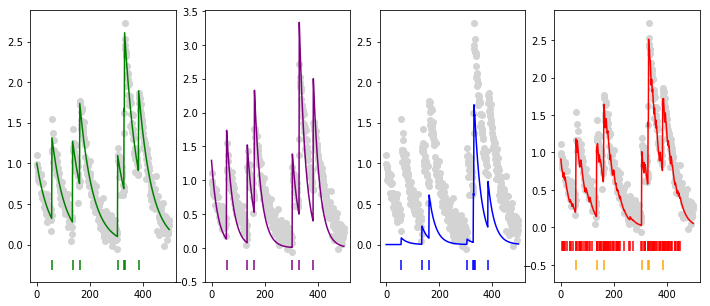

In [15]:
plt.figure(1,figsize=(12,5))
plt.subplot(141)
plt.scatter(x=np.arange(0,len(y_small_dat)),y=y_small_dat,color='lightgrey')
plt.plot(c_small_dat,'green')
plt.scatter(s_t_true,y = np.repeat(-0.25,len(s_t_true)),color='green',marker="|",s=100)
# plot l_0
plt.subplot(142)
plt.scatter(x=np.arange(0,len(y_small_dat)),y=y_small_dat,color='lightgrey')
plt.plot(c_cp_hat,'purple')
plt.scatter(s_t_backtrack[1:],y = np.repeat(-0.25,len(s_t_backtrack[1:])),color='purple',marker="|",s=100)

plt.subplot(143)
plt.scatter(x=np.arange(0,len(y_small_dat)),y=y_small_dat,color='lightgrey')
plt.plot(c_t_l1,'blue')
plt.scatter(np.where(s_t_l1>0)[0],\
            y = np.repeat(-0.25,len(np.where(s_t_l1>0)[0])),color='blue',marker="|",s=100)

plt.subplot(144)
plt.scatter(x=np.arange(0,len(y_small_dat)),y=y_small_dat,color='lightgrey')
plt.plot(c_t_l1_fit_c,'red')
plt.scatter(np.where(s_t_l1_fit_c>0)[0],\
            y = np.repeat(-0.25,len(np.where(s_t_l1_fit_c>0)[0])),color='red',marker="|",s=100)

plt.scatter(np.where(s_t_l1_fit_c>0.25)[0],\
            y = np.repeat(-0.5,len(np.where(s_t_l1_fit_c>0.25)[0])),color='orange',marker="|",s=100)
